# Sentimental Analysis of Movie Reviews using RNN(LSTM)

The purpose of this research is to use recurrent neural networks with long-short-term memory (LSTM) architecture to do sentiment analysis on IMDB movie reviews. Based on their textual content, the goal is to categorize movie reviews as either good or negative.The outcome of this project will be a model that can accurately classify movie reviews into positive or negative sentiments, which can be used to classify new movie reviews in the future.

The IMDB dataset is a widely used dataset for sentiment analysis, particularly for text classification tasks. It contains a collection of 50,000 movie reviews, which are labeled as positive or negative based on their sentiment.  Each set contains an equal number of positive and negative reviews. The reviews were collected from the IMDb website, a popular movie and TV show review site. The reviews are stored in text format and are relatively long, typically containing multiple sentences. The dataset contains a mix of reviews for different types of movies, including action, drama, comedy, and horror.

In [1]:
#Importing Dependencies

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

from keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

In [2]:
# Importing IMDb Movie Reviews dataset

mv_reviews = pd.read_csv("IMDB_Dataset.csv")



In [3]:
# Dataset exploration

mv_reviews.shape

(50000, 2)

In [4]:
mv_reviews.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
# Checking for missing values

mv_reviews.isnull().values.any()

False

<AxesSubplot:xlabel='sentiment', ylabel='count'>

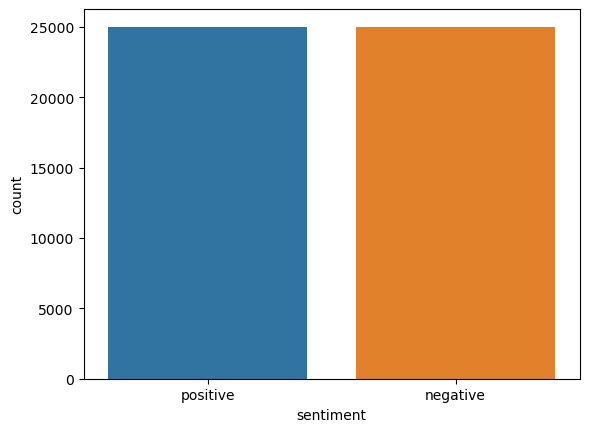

In [6]:
#Let's observe distribution of positive / negative sentiments in dataset

import seaborn as sns
sns.countplot(x='sentiment', data=mv_reviews)

From the above graph ,we can observe that dataset contains equal number of values for both categories of review.

In [7]:
mv_reviews["review"][1]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

We can see that our text contains punctuations, brackets, HTML tags and numbers. We need to preprocess this text for the analysis.

In [8]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bavig\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    
    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence) # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [11]:
#Initializing preprocessing_text function on mv_reviews

X = []
sentences = list(mv_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [12]:
# Looking for Sample cleaned up movie review 

X[5]

# As we shall use Word Embeddings, stemming/lemmatization is not performed as a preprocessing step here

'probably time favorite movie story selflessness sacrifice dedication noble cause preachy boring never gets old despite seen times last years paul lukas performance brings tears eyes bette davis one truly sympathetic roles delight kids grandma says like dressed midgets children makes fun watch mother slow awakening happening world roof believable startling dozen thumbs movie '

In [13]:
# Converting sentiment labels to 0 & 1

y = mv_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# The train set will be used to train our deep learning models 
# while test set will be used to evaluate how well our model performs 

In [15]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

Embedding layer expects the words to be in numeric form.Using Tokenizer function,fit_on_text() trains the tokenizer and   
texts_to_sequences() converts sentences to their numeric form.

In [16]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

92394

In [17]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [18]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [19]:
# Creating Embedding Matrix consists of 100 columns inorder to have 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [20]:
# Examining the shape of our dataset after creating embedding matrix
embedding_matrix.shape

(92394, 100)

5.1 Simple Neural Network

In [22]:
#Neural Network Architecture
from keras import regularizers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


nn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

nn_model.add(embedding_layer)

nn_model.add(Flatten())
nn_model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
nn_model.add(Dense(1, activation='sigmoid'))

nn_model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['acc'])


print(nn_model.summary())

nn_model_history = nn_model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2, callbacks=[EarlyStopping(patience=2)])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 flatten_1 (Flatten)         (None, 10000)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                640064    
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9,879,529
Trainable params: 640,129
Non-trainable params: 9,239,400
_________________________________________________________________
None
Epoch 1/10
250/250 [==============================] - 22s 82ms/step - loss: 0.8181 - acc: 0.7255 - val_loss: 0.6416 - val_acc: 0.7355
Epoch 2/10
250/250 [===========

In [23]:
# Predictions on the Test Set

score = nn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 32s 101ms/step - loss: 0.6052 - acc: 0.7531


In [24]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.6052390336990356
Test Accuracy: 0.7530999779701233


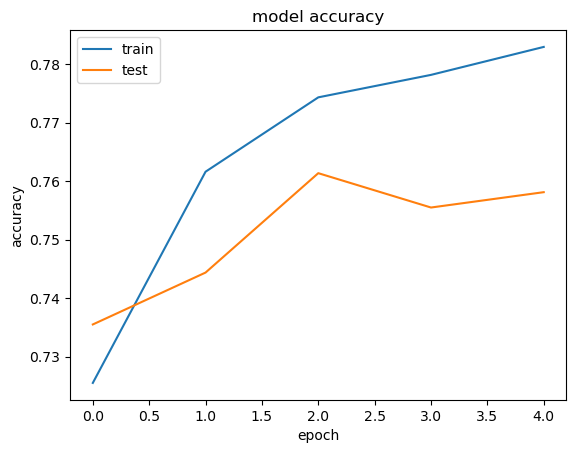

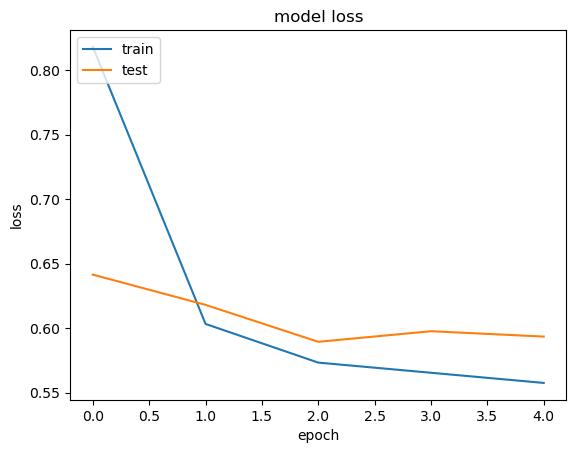

In [25]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(nn_model_history.history['acc'])
plt.plot(nn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(nn_model_history.history['loss'])
plt.plot(nn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

5.2 Convolutional Neural Network

In [26]:
#Convolutional Neural Network architecture

from keras import regularizers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Conv1D, GlobalMaxPooling1D

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

print(cnn_model.summary())

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2, callbacks=[EarlyStopping(patience=2)])


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9,303,657
Trainable params: 64,257
Non-trainable params: 9,239,400
_________________________________________________________________
None
Epoch 1/10
250/250 [==============================] - 29s 113ms/step - loss: 0.8129 - acc: 0.7742 - 

In [27]:
# Predictions on the Test Set

score = cnn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 4s 12ms/step - loss: 0.4562 - acc: 0.8390


In [28]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.4561852514743805
Test Accuracy: 0.8389999866485596


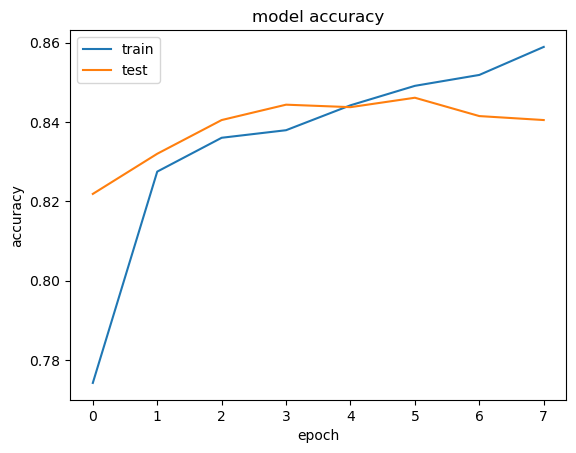

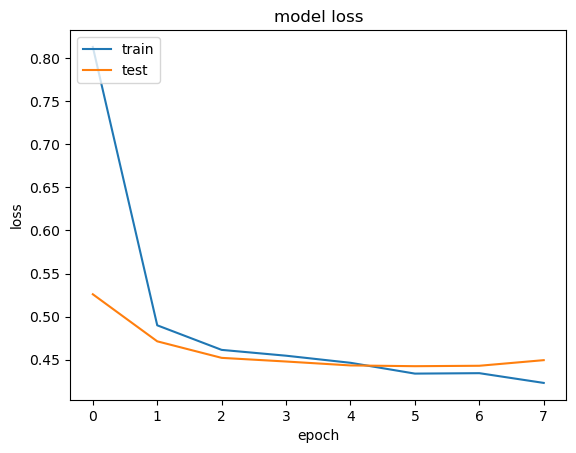

In [29]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

5.3 Recurrent Neural Network (LSTM)

In [30]:
# Recurrent Neural Network architecture

from keras import regularizers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import LSTM

lstm_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
lstm_model.add(embedding_layer)

lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

print(lstm_model.summary())

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9,356,777
Trainable params: 117,377
Non-trainable params: 9,239,400
_________________________________________________________________
None
Epoch 1/6
250/250 [==============================] - 94s 354ms/step - loss: 0.5009 - acc: 0.7551 - val_loss: 0.4221 - val_acc: 0.8106
Epoch 2/6
250/250 [==============================] - 81s 325ms/step - loss: 0.4076 - acc: 0.8188 - val_loss: 0.3876 - val_acc: 0.8345
Epoch 3/6
250/250 [==========

In [32]:
# Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 19s 61ms/step - loss: 0.3331 - acc: 0.8544


In [33]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.33307787775993347
Test Accuracy: 0.8543999791145325


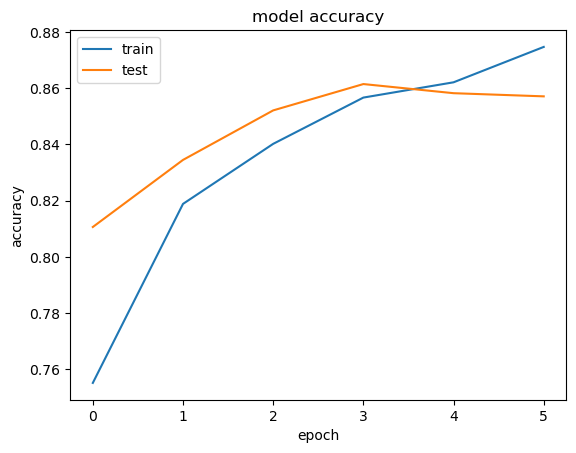

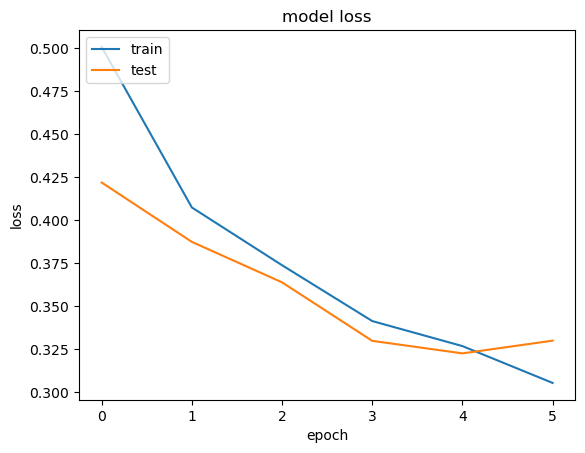

In [35]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [36]:
# Saving the model as a h5 file for possible use later

lstm_model.save(f"./c1_Lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')

The h5 format indicates that the model is being saved using the HDF5 file format, which is a popular format for storing large numerical datasets. The saved model can later be loaded and used for predictions or further training

In [37]:
# Load sample IMDb reviews csv, having ~6 movie reviews, along with their IMDb rating

sample_reviews = pd.read_csv("IMDb_Unseen_Reviews.csv")

sample_reviews.head(6)

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10
5,5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3


In [38]:
# Preprocess review text with earlier defined preprocess_text function

unseen_reviews = sample_reviews['Review Text']

unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [39]:
# Tokenising instance with earlier trained tokeniser
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

# Pooling instance to have maxlength of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [41]:
# Passing tokenised instance to the LSTM model for predictions
unseen_sentiments = lstm_model.predict(unseen_padded)

unseen_sentiments

1/1 [==============================] - 4s 4s/step


array([[0.763774  ],
       [0.9789643 ],
       [0.22715168],
       [0.40613016],
       [0.94862884],
       [0.03733908]], dtype=float32)

In [42]:
#Generating predictions for the sentiment of the unseen reviews using the LSTM model

sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)

df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_movie                 = pd.DataFrame(sample_reviews['Movie'], columns = ['Movie'])
df_review_text           = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
df_imdb_rating           = pd.DataFrame(sample_reviews['IMDb Rating'], columns = ['IMDb Rating'])


dfx=pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)

dfx.to_csv("./c2_IMDb_Unseen_Predictions.csv", sep=',', encoding='UTF-8')

dfx.head(6)

,Movie,Review Text,IMDb Rating,Predicted Sentiments
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,7.6
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,9.8
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,2.3
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,4.1
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,9.5
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3,0.4


We can observe from the above prediction that LSTM model is performing well in predicting the sentiment of movie reviews with accuracy of 85% compared to simple neural network and convolutional neural network.